In [1]:
# PARTS-based script to import GMM-derived rain DSDs, set up a model atmosphere with
#  a liquid cloud and a rain layer below it, and simulate GMI-type observations' spread
#  from using fixed RWP with different DSDs 
# [simon wrote much of the below]

# cleaned up in mid dec, d duncan, and committed to github

%env ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles
%load_ext autoreload
%autoreload 2
from data_provider import DataProvider
import numpy as np
plt.style.use('bmh')

env: ARTS_INCLUDE_PATH=/home/dudavid/arts/controlfiles


## PSD Data

In [2]:
ngmm = 6 # number of GMM classes from input data
data = np.load("ND_rwcnorm_"+str(ngmm)+".npy") 
# mean GMM class 1 data (just as example), output from table.ipynb
print(data.shape)
ex = np.load('oceanrain_binsizes.npy')[12:(12+data.shape[1])] # as defined by OR, saved in npy for convenience
x = ex/1e3 # from mm into m
ex = x # save for later use
print(x.shape, ex)

(6, 60)
(60,) [0.00039 0.00042 0.00046 0.00049 0.00053 0.00057 0.00061 0.00065 0.00069
 0.00073 0.00077 0.00082 0.00086 0.00091 0.00096 0.00101 0.00106 0.00111
 0.00116 0.00121 0.00127 0.00132 0.00138 0.00144 0.0015  0.00156 0.00163
 0.00169 0.00176 0.00183 0.0019  0.00197 0.00204 0.00212 0.0022  0.00228
 0.00236 0.00244 0.00253 0.00261 0.0027  0.0028  0.00289 0.00299 0.00309
 0.00319 0.00329 0.0034  0.00351 0.00362 0.00373 0.00385 0.00397 0.00409
 0.00422 0.00435 0.00448 0.00462 0.00476 0.0049 ]


In [3]:
def mgd(in_D,in_Dm,in_mu,in_RWC): #Nw):
    """
     Calcuate the Modified Gamma drop size distribution

     Input (note, all inputs should be vectors of same size!) : 
            in_D:  vector of diameters [mm]
            in_Dm: mass-weighted mean diameter [mm]
            in_mu: shape parameter [dim-less]
            in_RWC: RWC [kg m-3]
            #in_Nw: normalized intercept parameter [IN LOG10()!!] [mm-1 m-3]
     output: N(D) [len(in_D)] in m^{-3} mm^{-1}
    """
    if(len(in_D)==1):
        print("need to input vector for in_D")
    enot = (4**4)/(np.pi*1000.0) * in_RWC/((in_Dm*1e-3)**4) *1e-3 
    # calc intercept param from RWC, Dm -- get units into mm-1 m-3
    #enot = 10**in_Nw
    eff = 6/(4**4) * ((4+in_mu)**(4+in_mu) ) / math.gamma(np.float128(4+in_mu))
    ModGam = enot * eff * (in_D/in_Dm)**in_mu * np.exp(-(4+in_mu)*in_D/in_Dm)
    return ModGam

## Data provider

The data provider provides the data describing the atmospheric state. [set in external file]

[101300  90400  80500  71500  63300  55900  49200  43200  37800  32900
  28600  24700  21300  18200  15600  13200  11100   9370   7890   6660
   5650   4800   4090   3500   3000   2570   1763   1220    852    600
    426    305    220    159    116]
[    0.  1000.  2000.  3000.  4000.  5000.  6000.  7000.  8000.  9000.
 10000. 11000. 12000. 13000. 14000. 15000. 16000. 17000. 18000. 19000.
 20000. 21000. 22000. 23000. 24000. 25000. 27500. 30000. 32500. 35000.
 37500. 40000. 42500. 45000. 47500.]
[0.0001 0.0001] [101300  90400] [   0. 1000.]


(0, 18)

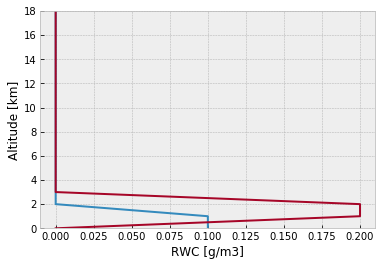

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt


rwp = 100e-3     # set RWP [kg/m2]
lwp = 200e-3  # set CLWP [kg/m2]
p0  = 101300 #e5   # lower bound of rain layer (pressure [Pa])
p1 = 9.04e4    # upper ""  --- CANNOT MAKE THINNER WITHOUT ADJUSTING DATAPROVIDER FILE
p2 = 7.8e4

data_provider = DataProvider(rwp, p0, p1, lwp, p1, p2)

# vars just defined here for plotting
p  = data_provider.get_pressure() # if no arg, P is defined as in external DP file
print(p)
z  = data_provider.get_altitude() # """"""
print(z)
md = data_provider.get_rain_mass_density() # in kg/m3
md_cloud = data_provider.get_cloud_mass_density() # in kg/m3
print(md[0:2],p[0:2],z[0:2])


plt.plot(md*1e3, z / 1e3) # alt from m to km
plt.plot(md_cloud*1e3, z / 1e3) # alt from m to km
plt.xlabel("RWC [g/m3]")
plt.ylabel("Altitude [km]")
plt.ylim([0,18])

## Scattering data

We need to interpolate the psd data to match the liquid sphere scattering data.

In [6]:
# load scattering data from Dendrite, then interpolate to match database
ssdb_path = "/home/dudavid/Dendrite/Dendrite/SSDB/ArtsScatDbase/ArtsScatDbase_v1.0.0/StandardHabits/FullSet/"
#ssdb_path = "/home/dudavid/Dendrite/Dendrite/SSDB/SSDB_temp/StandardHabits/"
# 2nd SSDB path has much more spectral resolution ## and takes longer to run
scattering_data = ssdb_path + "LiquidSphere.xml"
scattering_meta = ssdb_path + "LiquidSphere.meta.xml"
from typhon.arts.xml import load
sd = load(scattering_data)
sd_meta = load(scattering_meta)

sd_grid = np.array([m.diameter_volume_equ for m in sd_meta])
sd_grid * 1e3 # so, into m
print('scat data pts in mm: ',sd_grid*1000)

psd_x = sd_grid
psd_shape = np.interp(sd_grid, x, data[0, :])

scat data pts in mm:  [1.2429443e-03 1.0558760e-03 1.6312339e-03 2.1408232e-03 2.9665952e-03
 2.6609240e-03 4.3405893e-03 6.0148691e-03 7.0805163e-03 9.2924343e-03
 1.1549978e-02 1.5158134e-02 1.8840715e-02 2.4726461e-02 3.0733613e-02
 4.0334641e-02 5.0133711e-02 6.5795232e-02 8.1779807e-02 1.0732741e-01
 1.3340199e-01 1.7507611e-01 2.2976901e-01 2.8559008e-01 3.7480700e-01
 4.6586421e-01 6.1139787e-01 7.5993348e-01 9.9733292e-01 1.2396292e+00
 1.6268832e+00 2.0221252e+00 2.6538270e+00 3.2985591e+00 4.3290126e+00
 5.3807214e+00 7.0616320e+00 8.7772150e+00 1.1519173e+01 1.4317690e+01
 1.8790466e+01 2.3355502e+01 3.0651644e+01 3.8098285e+01 5.0000000e+01]


In [ ]:
# verify that interpolated DSD matches the input closely [check]
plt.figure(figsize=[10,7])
for p in range(ngmm):
    yessir = np.interp(sd_grid, x, data[p, :])
    yessir[psd_x > .006] = 0.0
    yessir[psd_x < .0001] = 0.0
    #print(yessir)
    plt.plot(psd_x*1000, yessir , label=str(p+1))
    #plt.plot(psd_x*1000, np.interp(sd_grid, x, data[p, :]) , label=str(p+1))
#plt.plot(psd_x*1000, np.interp(sd_grid, x, mgd(x*1000,Dmi,mui,0.0003)))#data_provider.get_rain_mass_density()[0])))
plt.yscale("log")
plt.xlim([.01,7])
plt.ylim([1e-1,2e4])
plt.legend()

## Parts simulation -- import parts

In [7]:
import sys
sys.path += ["/home/dudavid/src/parts"] # to verify that PARTS is in the system path
#sys.path

In [8]:
from parts import ArtsSimulation
from parts.scattering import ScatteringSpecies
from parts.atmosphere import Atmosphere1D
from parts.sensor import PassiveSensor, ICI
from parts.atmosphere.absorption import O2, N2, H2O
from parts.atmosphere.surface import Tessem
from parts.scattering.solvers import RT4, Disort

Loading ARTS API from: /home/dudavid/arts/build/src/libarts_api.so


### Fixed-shape psd

The FixedShape class  represents PSD data that has a fixed shape. It takes the mass density profile provided by the data provider and multiplies it with the normalized PSD shape.

In [9]:
from parts.scattering.psd.fixed_shape import FixedShape
#from parts.scattering.psd.modified_gamma import ModifiedGamma

psd = FixedShape(psd_x, psd_shape)

#psd_mgd = ModifiedGamma()
# instead of using ModifiedGamma function... calculate manually and set as new fixed shape
Dmi, mui = 1.5, 2

#mgd_shape = mgd(x*1000, 1.3, 3, data_provider.get_rain_mass_density() ) # D, Dm, mu, RWC
#psd_shape_mgd = np.interp(sd_grid, x, mgd_shape)
mgd_psd = FixedShape(psd_x, np.interp(sd_grid,x,mgd(x*1000, Dmi, mui, data_provider.get_rain_mass_density()[0])))
#plt.plot(x*1000, mgd(x*1000, Dmi, mui, data_provider.get_rain_mass_density()[0]))

### Atmosphere

In [10]:
from parts.scattering.psd import D14  # Delanoe 2014 PSD (for now, since it's in parts)
# add cloud layer properties
cloud = ScatteringSpecies("cloud", D14(1.0, 2.0, rho = 1000.0),
                        scattering_data = scattering_data,
                        scattering_meta_data = scattering_meta)

In [11]:
# add rain species, setup atmospheric abs and scat species, plus surface

rain = ScatteringSpecies("rain", psd,
                        scattering_data = scattering_data,
                        scattering_meta_data = scattering_meta)

atmosphere = Atmosphere1D(absorbers = [O2(), N2(), H2O()],
                          scatterers = [rain, cloud],
                          surface = Tessem())  # Tessem sfc model currently only option in PARTS

### Sensor

In [12]:
#channels = np.array([10.65e9, 18.7e9, 23.8e9, 36.65e9, 89e9]) #, 166e9, 180.31e9, 190.31e9]) # made-up sensor for now

channels = np.array([19e9, 36.5e9, 89e9]) # picked 3 GMI frequencies
#channels = np.array([18.7e9, 36.64e9, 89e9]) # picked 3 GMI frequencies
ch_str = ['18GHz','36GHz','89GHz']
nch = channels.size
gmi = PassiveSensor("gmi", channels, stokes_dimension = 1) 
gmi.sensor_line_of_sight = np.array([[135.0]]) # angle from SC, not EIA
gmi.sensor_position = np.array([[407e3]]) # alt in m
gmi.iy_unit = "PlanckBT"  # since using Disort, no V/H polarization information...

### Running the simulation

In [13]:
from typhon.arts.workspace.api import arts_api

In [14]:
simulation = ArtsSimulation(atmosphere = atmosphere,
                            data_provider = data_provider,
                            sensors = [gmi])
#simulation.scattering_solver = Disort() 
#RT4(nstreams = 8, auto_inc_nstreams = 8, robust = 1) # use this or else problems?


#simulation.scattering_solver = RT4(nstreams = 4, auto_inc_nstreams = 16, robust = 1) # use this or else problems?
simulation.scattering_solver = Disort(nstreams = 32)
simulation.setup()
simulation.run()
print("TEST SIMULATION: ")
print(gmi.y)

ARTS[94357369431792]: Executing /home/dudavid/arts/controlfiles/general/general.arts
ARTS[94357369431792]: {
ARTS[94357369431792]: - verbosityInit
ARTS[94357369431792]: - scat_speciesSet
ARTS[94357369431792]: - MatrixSet
ARTS[94357369431792]: - Tensor4SetConstant
ARTS[94357369431792]: - ArrayOfStringSet
ARTS[94357369431792]: - Touch
ARTS[94357369431792]: - Tensor3SetConstant
ARTS[94357369431792]: - ArrayOfStringSet
ARTS[94357369431792]: - MatrixSet
ARTS[94357369431792]: - NumericSet
ARTS[94357369431792]: - ArrayOfStringSet
ARTS[94357369431792]: - Tensor3SetConstant
ARTS[94357369431792]: - Tensor3SetConstant
ARTS[94357369431792]: - Tensor3SetConstant
ARTS[94357369431792]: - Tensor3SetConstant
ARTS[94357369431792]: - Tensor3SetConstant
ARTS[94357369431792]: - Tensor3SetConstant
ARTS[94357369431792]: - IndexSet
ARTS[94357369431792]: - IndexSet
ARTS[94357369431792]: - IndexSet
ARTS[94357369431792]: - IndexSet
ARTS[94357369431792]: - FlagOff
ARTS[94357369431792]: - output_file_formatSetAsci

ARTS[94357369431792]: - ReadXML

ARTS[94357369431792]: - ReadXML

ARTS[94357369431792]: - Append

ARTS[94357369431792]: - Append

ARTS[94357369431792]: - Delete

ARTS[94357369431792]: - Delete

ARTS[94357369431792]: - Append

ARTS[94357369431792]: - Append

ARTS[94357369431792]: - Append

ARTS[94357369431792]: - Copy

ARTS[94357369431792]: - ReadXML

ARTS[94357369431792]: - ReadXML

ARTS[94357369431792]: - Append

ARTS[94357369431792]: - Append

ARTS[94357369431792]: - Delete

ARTS[94357369431792]: - Delete

ARTS[94357369431792]: - Append

ARTS[94357369431792]: - Append

ARTS[94357369431792]: - Append

ARTS[94357369431792]: - Copy

ARTS[94357369431792]: - TessemNNReadAscii

ARTS[94357369431792]: - TessemNNReadAscii

ARTS[94357369431792]: - Copy

ARTS[94357369431792]: - Copy

ARTS[94357369431792]: - Copy

ARTS[94357369431792]: - Copy

ARTS[94357369431792]: - Copy

ARTS[94357369431792]: - Copy

ARTS[94357369431792]: - Copy

ARTS[94357369431792]: - scat_dataCalc

ARTS[94357369431792]: - C

ARTS[94357369431792]: - DisortCalcWithARTSSurface

ARTS[94357369431792]: - yCalc

TEST SIMULATION: 
[[205.69932797]
 [233.73277509]
 [283.56370351]]


In [15]:
#FixedShape.shape?
ws = simulation.workspace
ws.verbositySet(agenda = 0, screen = 0, file = 0)

ARTS[94357369431792]: - verbositySet



In [16]:
# run a case with RWP=0 to form base case
data_provider.rwp = 0
simulation.run()
base_tb = np.array(np.copy(gmi.y).ravel())
print('BASE TB with RWP=0: ',base_tb)
np.save('savetb/base',base_tb) # be careful this is from the same setup

BASE TB with RWP=0:  [203.81930357 230.36897711 281.10786743]


In [ ]:
# try running through RWP values and assess spread in Tb intensity
# THIS WILL TAKE HOURS IF USING MANY DATA POINTS!!!!!
rwp_max = 0.6
rwp_step = .08
rwp_vals = np.arange(0.001,rwp_max,rwp_step) # since 0 will be same for all

sv_tb = np.zeros([nch, rwp_vals.size, ngmm+1])
print(sv_tb.shape)

for r in range(len(rwp_vals)):
    print('RWP loop: ',rwp_vals[r])
    for s in range(ngmm):
        data_provider.rwp = rwp_vals[r]
        new_shape = np.interp(sd_grid, x, data[s,:])
        new_shape[sd_grid > .006] = 0.0 # limiting weird stuff from huge drops
        new_shape[sd_grid < .0001] = 0.0
        simulation.atmosphere.scatterers[0].psd.set_shape( new_shape )
        simulation.run()
        sv_tb[:,r,s] = np.ravel(np.copy(gmi.y)) #-base_tb
        #print(s,np.trapz(psd.shape.ravel() * psd_x ** 3, x = psd_x), data_provider.rwp) # verify mass-weighted drops
        
    # then with a token MGD curve -- defined above
    new_shape = np.interp(sd_grid, x, mgd(x*1000,Dmi,mui,1.0)) # fixedshape will normalize, so rwc doesn't matter
    new_shape[sd_grid > .006] = 0.0 # limiting weird stuff from huge drops
    new_shape[sd_grid < .0001] = 0.0
    simulation.atmosphere.scatterers[0].psd.set_shape( new_shape )
    simulation.run()
    sv_tb[:,r,s+1] = np.ravel(np.copy(gmi.y)) #-base_tb
    psd = simulation.atmosphere.scatterers[0].psd

In [ ]:
psd.psd.get_mass_density()
from copy import copy
psd_2 = copy(psd)
psd_2.psd.data = psd.shape
psd_2.psd.get_mass_density()
psd_2.size_parameter.b

In [ ]:
psd = simulation.atmosphere.scatterers[0].psd
#plt.plot(psd_x, psd.shape.ravel())

In [ ]:
plt.style.use('bmh')
fs=14
for c in range(len(channels)):
    fx=plt.figure(figsize=[14,9])
    plt.plot(rwp_vals, sv_tb[c,:,s+1]-bass[c],'k--',label=ch_str[c]+', MGD ($D_m$='+str(Dmi)+', $\mu$='+str(mui)+')')
    for s in range(ngmm):
        plt.plot(rwp_vals, sv_tb[c,:,s]-bass[c],'--',label=ch_str[c]+', GMM'+str(s+1))
    plt.legend(fontsize=fs,loc='upper left')
    plt.xlabel(r"RWP [$kg m^{-2}$]",fontsize=fs+4)
    plt.ylabel('$\Delta T_B$ [K]',fontsize=fs+4)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    fx.savefig('../img/gmm_passive_clwp200.'+ch_str[c]+'.v1.png',dpi=300)

In [17]:
print(info(sv_tb))
plt.style.use('bmh')
plt.figure(figsize=[14,9])
fs=14
plt.plot(rwp_vals, sv_tb[0,:,s+1]-bass[0],'k--', label=ch_str[0]+', MGD ($D_m$='+str(Dmi)+', $\mu$='+str(mui))
plt.plot(rwp_vals, sv_tb[1,:,s+1]-bass[1],'-.',  label=ch_str[1]+', MGD')
plt.plot(rwp_vals, sv_tb[2,:,s+1]-bass[2],'k',   label=ch_str[2]+', MGD ($D_m$='+str(Dmi)+', $\mu$='+str(mui))
for s in range(ngmm):
    plt.plot(rwp_vals, sv_tb[0,:,s]-bass[0],'--',label=ch_str[0]+', GMM'+str(s+1))
    plt.plot(rwp_vals, sv_tb[1,:,s]-bass[1],'-.',label=ch_str[1]+', GMM'+str(s+1))
    plt.plot(rwp_vals, sv_tb[2,:,s]-bass[2],     label=ch_str[2]+', GMM'+str(s+1))
plt.legend(fontsize=fs,loc='upper left')
plt.xlabel(r"RWP [$kg m^{-2}$]",fontsize=fs+4)
plt.ylabel('$\Delta T_B$ [K]',fontsize=fs+4)

plt.figure(figsize=[14,9])
for ch in range(len(channels)):
    plt.plot(rwp_vals, np.std(sv_tb[ch,:,:ngmm], axis=1), label=ch_str[ch])
fs=14
#plt.title("Stddev(TB) with "+str(ngmm)+" classes",fontsize=fs)
plt.xlabel(r"RWP [$kg m^{-2}$]",fontsize=fs+4)
plt.ylabel("$\sigma (T_B)$ [K]",fontsize=fs+4)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs,loc='upper left')

NameError: name 'sv_tb' is not defined

In [ ]:
#ws = simulation.workspace
#y  = ws.pnd_field
#
#psd = simulation.atmosphere.scatterers[0].psd
#x = psd._wsvs["x"]
#x.ws = simulation.workspace
##plt.plot(x.value[:] * 1000.0, y.value[:, 0, 0, 0])
##plt.yscale("log")
##plt.xlim([.3,4])
#

In [25]:
# Running the simulation setup for 'native' OceanRAIN data... read in output from collate_m first
#  then use the fixed shape parts call to run fwd model without modifying input data.
typ = 'MSs3'
dir_raw_data = "/home/dudavid/projects/dsd/dj/data/"
lo = np.load(dir_raw_data+'alllond'+typ+'.npy')# [::per]
la = np.load(dir_raw_data+'alllatd'+typ+'.npy')# [::per]
epo= np.load(dir_raw_data+'allepochd'+typ+'.npy')# [::per]
rcts = np.load(dir_raw_data+'rallcts'+typ+'.80.npy').transpose()#[::per,:] # raw (per mm) counts

# averaging over consecutive time steps to give a little spatial averaging sense
#   [if location varies very little for consecutive points then put them together]

en = np.size(lo)
rcts_newer = rcts
mo = 3   # this is smoothing referred to in the paper:
if mo > 0: 
    smoof = 'S' 
else:
    smoof=''
c=0
for f in range(en-2*mo)[mo:]:
    space_var = np.std(lo[(f-mo):(f+mo+1)])+np.std(la[(f-mo):(f+mo+1)])
    time_var  = np.std(epo[(f-mo):(f+mo+1)])
    if space_var < 0.1 and time_var < 500:  # so ~10km max, mostly within 5min?
        rcts_newer[f,:] = np.mean(rcts[(f-mo):(f+mo+1),:], axis=0)
        c+=1
print(c,'smoof='+smoof)
        
# take every _th point to save time:
per = 3 #00

rcts_newer = rcts_newer[::per,:]
dm = np.load(dir_raw_data+'alldmd'+typ+'.npy')[::per]
rr = np.load(dir_raw_data+'allrrd'+typ+'.npy')[::per]
ku = np.load(dir_raw_data+'allkud'+typ+'.npy')[::per]
ka = np.load(dir_raw_data+'allkad'+typ+'.npy')[::per]
mu = np.load(dir_raw_data+'allmud'+typ+'.npy')[::per]
nw = np.log10( np.load(dir_raw_data+'allnwd'+typ+'.npy')[::per] ) # given as log10()
print(np.mean(mu),np.mean(dm),np.mean(nw))
nor = dm.size
#vcts = np.load(dir_raw_data+'vallcts'+typ+'.80.npy').transpose()[::per,:] # vol-weighted, smoothed
#ncts = np.load(dir_raw_data+'normallcts'+typ+'.80.npy').transpose()[::per,:] # vol-weighted and normalized
#rcts = np.load(dir_raw_data+'rallcts'+typ+'.80.npy').transpose()[::per,:] # raw (per mm) counts
#scts = np.load(dir_raw_data+'snallcts'+typ+'.80.npy').transpose()[::per,:] # smoothed, normalized, not weighted
#rwcts =np.load(dir_raw_data+'rwallcts'+typ+'.80.npy').transpose()[::per,:] # RWC-normalized raw
cts = rcts_newer # choose which one to use

# read in 80 size bins above, trim to __ in rest of code
mb = 60
bye = 1 # how many consecutive bins to sum/avg over
cts_new = np.array([ np.mean(cts[:,x*bye:(x*bye+bye)],axis=1) for x in range(int(mb/bye)) ]).transpose()
#rcts_new= np.array([ np.mean(rcts[:,x*bye:(x*bye+bye)],axis=1) for x in range(int(mb/bye)) ]).transpose()
#print(cts_new.shape)


71228 smoof=S
4.4836983325734385 1.179782094704618 3.6967294713179935


In [26]:
#d_mid = np.array([ np.mean(ex[n:n+2]) for n in range(int(mb/bye)) ]) # diam midpoint in m
#dD = [1e3*(ex[n+1]-ex[n]) for n in range(len(ex)-1)]  #delta D in mm

# calculate RWC from the raw data  i.e. RWC = rho*sum(4/3 pi r^3 dr)
LWC = np.array([1000.0*1000.0*np.pi/6 * np.trapz( cts_new[i,:] * (ex[:])**3, ex) for i in range(nor)]) 
# should be in kg/m^3 (so multiply by maybe 500m to get an idea of rwp)

print(info(LWC))
np.save('savetb/OR_native'+smoof+'_LWC.every'+str(per),LWC) ## NOTE SMOOTHED OR NOT WITH 'S' (set above)

['5.36E-6', '6.83E-3', '1.81E-4', '2.93E-4']


In [ ]:
zees = data_provider.get_altitude()[data_provider.get_rain_mass_density() > 0] #.size
print(zees) # tops of atmospheric levels
deltaz = 1000 #zees[-1] #- 0 # should give change in altitude, RWP depth
# THIS ASSUMES RAIN LAYER IS UNIFORM, ETC. AS ASSUMED ABOVE
print(deltaz)

In [ ]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y[1:], box, mode='same')
    y_smooth = np.append(y[0],y_smooth) # to leave first point unmolested\n",
    return y_smooth

# Assess Tb sensitivity if using GMM classes vs. MGD with set mu

In [ ]:
# data output from gmm_solo, saved as npy arrays for labels (1 to nc) and posterior probabilities of 0 to 1

nc = 6 #10 # number of classes (IF NOT CORRECT (with what's been run) THIS WILL GIVE BAD RESULTS)
inty = 'MSs3' # input data type -- extra s for more smoothing (n=5 instead of n=3)

ddir = '/home/dudavid/projects/dsd/dj/OceanClustering/Data_store/'
post_prob = np.load(ddir+'GMM-postprob_rwcnorm_'+str(nc)+'.'+inty+'.npy')[::per]
labels    = np.load(ddir+'GMM-labels_rwcnorm_'+str(nc)+'.'+inty+'.npy')[::per]

# re-read in the mean GMM vectors to ensure consistency:
gmm_means = np.load(ddir+'ND_rwcnorm_'+str(nc)+'.npy')

In [ ]:
tb_gmm = np.zeros([nor,nch]) # save TBs output from simulation
tb_mgd = np.zeros([nor,nch]) # save TBs output from simulation

for i in range(nor):
    data_provider.rwp = LWC[i]* deltaz # kg/m3 * m
    # use GMM-defined shape instead:
    new_shape = np.interp(sd_grid, x, gmm_means[labels[i],:])
    new_shape[np.logical_or(sd_grid > .006, sd_grid < .0003)] = 0.0 # limiting weird stuff from huge/tiny drops
    simulation.atmosphere.scatterers[0].psd.set_shape( new_shape )
    simulation.run()
    
    if np.mod(i,39)==0:  # just for checking as it runs
        print('TB:',np.copy(gmi.y).ravel(), data_provider.rwp,i,nor )
        
    tb_gmm[i,:] = np.ravel(np.copy(gmi.y))
    
np.save('savetb/OR_gmm_tbs_1kmlayer.every'+str(per),tb_gmm)
andstophere

In [ ]:
tb_mgd = np.zeros([nor,nch]) # save TBs output from simulation

for i in range(nor):
    data_provider.rwp = LWC[i]* deltaz # kg/m3 * m
    # use MGD-defined shape instead:
    new_shape = np.interp(sd_grid, x, mgd(x*1000, dm[i], 3.0, 1.0)) # fixedshape will normalize, so rwc doesn't matter
    #new_shape = np.interp(sd_grid, x, gmm_means[labels[i],:])
    new_shape[np.logical_or(sd_grid > .006, sd_grid < .0003)] = 0.0 # limiting weird stuff from huge/tiny drops
    simulation.atmosphere.scatterers[0].psd.set_shape( new_shape )
    simulation.run()
    
    if np.mod(i,39)==0:  # just for checking as it runs
        print('TB:',np.copy(gmi.y).ravel(), data_provider.rwp,i,nor )
        
    tb_mgd[i,:] = np.ravel(np.copy(gmi.y))
    
np.save('savetb/OR_mgd_tbs_1kmlayer.every'+str(per),tb_mgd)
#andstophere

# Assess 'natural' Tb sensitivity separated by RWC

In [ ]:
tb_or = np.zeros([nor,nch]) # save TBs output from simulation

for i in range(nor):
    data_provider.rwp = LWC[i]* deltaz # kg/m3 * m
    #if data_provider.rwp < 0.1:
    #    data_provider.rwp = 0.1 # kg/m3 * m
    new_shape = np.interp(sd_grid, x, smooth(cts_new[i,:],5))  # smooth to limit interp issues
    new_shape[np.logical_or(sd_grid > .006, sd_grid < .0003)] = 0.0 # limiting weird stuff from huge/tiny drops
    simulation.atmosphere.scatterers[0].psd.set_shape( new_shape )
    simulation.run()
    
    if np.mod(i,39)==0:  # just for checking as it runs
        print('TB:',np.copy(gmi.y).ravel(), data_provider.rwp, i,nor )
    tb_or[i,:] = np.ravel(np.copy(gmi.y))
    
np.save('savetb/OR_native'+smoof+'_tbs_1kmlayer.every'+str(per),tb_or) ## NOTE SMOOTHED OR NOT WITH 'S' (set above)

### Results

In [27]:
per = 3 # 3 is highest number run so far
# pre-supposes that smoothed and unsmoothed array have been run:
tborS= np.load('savetb/OR_nativeS_tbs_1kmlayer.every'+str(per)+'.npy') # smoothed!
tbor = np.load('savetb/OR_native_tbs_1kmlayer.every'+str(per)+'.npy') # unsmoothed!
lwcS = np.load('savetb/OR_nativeS_LWC.every'+str(per)+'.npy') 
lwcnS= np.load('savetb/OR_native_LWC.every'+str(per)+'.npy') 
bass = np.load('savetb/base.npy')
print(shinfo(tbor),shinfo(lwcnS))
print(shinfo(tborS),shinfo(lwcS))

deltaz=1000. # also sloppy
nch = 3

rwp_h = np.array([0,.02,.04,.06,.08,.1,.125,.15,.175,.2,.23,.265,.3,.35,.4,.45,.5,.6])
mnsS, mns  = np.zeros([rwp_h.size-1,nch]), np.zeros([rwp_h.size-1,nch])
stdsS,stds = np.zeros([rwp_h.size-1,nch]), np.zeros([rwp_h.size-1,nch])
for ar in range(rwp_h.size-1):
    ndex = np.logical_and(lwcnS*deltaz <= rwp_h[ar+1], lwcnS*deltaz > rwp_h[ar])
    sdex = np.logical_and(lwcS*deltaz <= rwp_h[ar+1], lwcS*deltaz > rwp_h[ar])
    mns[ar,:]  = np.mean( tbor[ndex,:]-bass, axis=0 )
    stds[ar,:] = np.std(  tbor[ndex,:], axis=0 )
    mnsS[ar,:]  = np.mean( tborS[sdex,:]-bass, axis=0 )
    stdsS[ar,:] = np.std(  tborS[sdex,:], axis=0 )


['2.04E+2', '2.89E+2', '2.49E+2', '3.04E+1', (30706, 3)] ['5.96E-6', '8.02E-3', '1.99E-4', '3.52E-4', (30706,)]
['2.04E+2', '2.89E+2', '2.49E+2', '3.01E+1', (30706, 3)] ['5.36E-6', '6.83E-3', '1.81E-4', '2.93E-4', (30706,)]


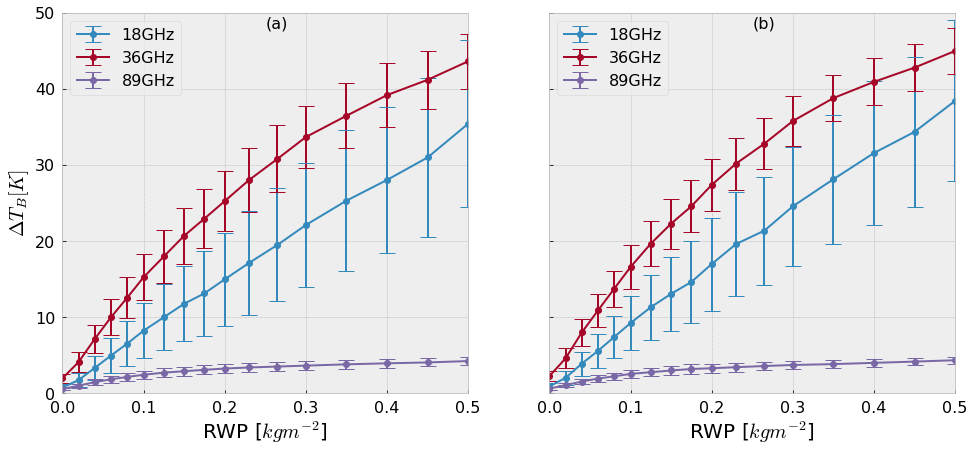

In [28]:
fie, ax = plt.subplots(nrows=1, ncols=2, figsize=[16,7],sharex=True,sharey=True)

fs = 16
for c in range(len(channels)):
    ax[0].errorbar(rwp_h[:-1], mns[:,c], stds[:,c], label=ch_str[c], fmt='-o', capsize=8)
ax[0].legend(fontsize=fs,loc='upper left')
ax[0].set_xlim([0,0.5])
ax[0].set_ylim([0,50])
ax[0].tick_params(labelsize=fs,axis='both',pad=7)
ax[0].set_ylabel('$\Delta T_B [K]$',fontsize=fs+4)
ax[0].set_xlabel('RWP [$kg m^{-2}$]',fontsize=fs+4)

for c in range(len(channels)):
    ax[1].errorbar(rwp_h[:-1], mnsS[:,c], stdsS[:,c], label=ch_str[c], fmt='-o', capsize=8)
ax[1].legend(fontsize=fs,loc='upper left')
ax[1].set_xlim([0,0.5])
ax[1].set_ylim([0,50])
ax[1].tick_params(labelsize=fs,axis='both',pad=7)
#ax[1].set_ylabel('$\Delta T_B [K]$',fontsize=fs+4)
ax[1].set_xlabel('RWP [$kg m^{-2}$]',fontsize=fs+4)
ax[1].text(.25, 48, '(b)', fontsize=fs)
ax[0].text(.25, 48, '(a)', fontsize=fs)


fie.savefig('../img/nat_passive_2pan_clwp200_3freq_v3_every'+str(per)+'.png',\
              dpi=300,bbox_inches='tight',transparent=True)

In [ ]:
#f_nat = plt.figure(figsize=[12,9])
#fs = 14
#for c in range(len(channels)):
#    ax[0].errorbar(rwp_h[:-1], mns[:,c], stds[:,c], label=ch_str[c], fmt='-o', capsize=8)
#plt.legend(fontsize=fs,loc='upper left')
#plt.xlim([0,0.5])
#plt.ylim([0,50])
#plt.xticks(fontsize=fs)
#plt.yticks(fontsize=fs)
#plt.ylabel('$\Delta T_B [K]$',fontsize=fs+4)
#plt.xlabel('RWP [$kg m^{-2}$]',fontsize=fs+4)
#
#f_nat.savefig('../img/nat_passive_clwp200_3freq_v2'+smoof+'_every'+str(per)+'.png',\
#              dpi=300,bbox_inches='tight',transparent=True)

# Radar variability

In [ ]:

# now do the same type of analysis, but with radar reflectivities (no need to fwd model!)

In [ ]:
rr_h = 2**(np.arange(-3,5,.15))
mns_dbz  = np.zeros([rr_h.size-1,2])
stds_dbz = np.zeros([rr_h.size-1,2])
for ar in range(rr_h.size-1):
    dex = np.logical_and(rr <= rr_h[ar+1], rr > rr_h[ar])
    ku_z, ka_z = 10**(ku[dex]*.1), 10**(ka[dex]*.1)
    mns_dbz[ar,:]  = [ np.mean( ku[dex] ),np.mean( ka[dex] )]
    stds_dbz[ar,:] = [ np.std(  ku[dex] ),np.std(  ka[dex] )] 
    

dbz_h = np.arange(12,45,1)
stds_rr =  np.zeros([dbz_h.size-1,2])
mns_rr =  np.zeros([dbz_h.size-1,2])
for ar in range(dbz_h.size-1):
    dexu = np.logical_and(ku <= dbz_h[ar+1], ku > dbz_h[ar])  # based on Ku refl only!
    dexa = np.logical_and(ka <= dbz_h[ar+1], ka > dbz_h[ar])  # based on Ka refl only!
    #print(info(rr[dexu]))
    mns_rr[ar,:] =  [ np.mean( rr[dexu] ),np.mean(  rr[dexa] )] 
    stds_rr[ar,:] = [ np.std( rr[dexu] ),np.std(  rr[dexa] )]


In [ ]:
r1 = plt.figure(figsize=[12,9])
fs = 14
bye = 3
plt.errorbar(rr_h[:-1:bye], mns_dbz[::bye,0], stds_dbz[::bye,0], label='$K_U$', fmt='-o', capsize=8)
plt.errorbar(rr_h[:-1:bye], mns_dbz[::bye,1], stds_dbz[::bye,1], label='$K_A$', fmt='-o', capsize=8)
plt.legend(fontsize=fs+4,loc='upper left')
plt.xscale('log')
plt.ylabel('Simulated reflectivity [$dBZ$]',fontsize=fs+4)
plt.xlabel('Rain rate [$mm h^{-1}$]', fontsize=fs+4)
plt.xticks(fontsize=fs+4)
plt.yticks(fontsize=fs+4)

r1.savefig('../img/nat_active_rr-sigdbz_2freq_v4.png',dpi=300,bbox_inches='tight',transparent=True)


In [ ]:
# NOTE: this plot is problematic because of two things:
#  1. OR has a 0.1mm/hr cutoff in recorded rain rate, plus the axis is log, so std deviations look very skewed
#  2. Some obs of very low reflectivities have very high rain rates, which also skews statistics heavily
# In some bins, std > mean and so the plot routine struggles to make bars :| 
sodontplothisrightnow

r2 = plt.figure(figsize=[12,9])
bye=1
plt.errorbar(dbz_h[:-1:bye], mns_rr[::bye,0], stds_rr[::bye,0], label='$K_U$', fmt='-o', capsize=8)
plt.errorbar(dbz_h[:-1:bye], mns_rr[::bye,1], stds_rr[::bye,1], label='$K_A$', fmt='-o', capsize=8)
#plt.plot(dbz_h[:-1], stds_rr[:,0], label='Ku')
#plt.plot(dbz_h[:-1], stds_rr[:,1], label='Ka')
plt.legend(fontsize=fs+4,loc='upper left')
plt.xticks(fontsize=fs+4)
plt.yticks(fontsize=fs+4)
plt.ylabel('Rain rate [$mm h^{-1}$]',fontsize=fs+4)
plt.yscale('log')
#plt.ylabel('$\sigma$(RR) [$mm hr^{-1}$]',fontsize=fs+4)
plt.xlabel('Simulated reflectivity [$dBZ$]',fontsize=fs+4)

r2.savefig('../img/nat_active_dbz-sigrr.2freq.v3.png',dpi=300,bbox_inches='tight',transparent=True)